# Sound anomaly detection
*Step 2 - Performing anomaly detection with an autoencoder architecture*

## Introduction
---
Here is [an article](https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048) you can go through to dive deeper into what an autoencoder is and how it can be used for anomaly detections.

## Initialization
---

### Configuration

In [1]:
# Python libraries:
import os
import sys
import random
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Other imports:
from sklearn import metrics
from tqdm import tqdm

# AWS and SageMaker libraries:
#import sagemaker
#import boto3
#from sagemaker.tensorflow import TensorFlow
import tensorflow as tf

sys.path.append('tools')
import sound_tools
import utils

sys.path.append('autoencoder')
import model as model_AE

In [2]:
# Initializations:
%matplotlib inline
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
blue = colors[1]
red = colors[5]

random.seed(42)
np.random.seed(42)
#sess = sagemaker.Session()
#role = sagemaker.get_execution_role()

# Paths definition:
DATA           = os.path.join('data', 'interim')
RAW_DATA       = os.path.join('data', 'raw')
PROCESSED_DATA = os.path.join('data', 'processed')

ROOT_DATA = os.path.join('/home/neaf/code/delta_anoamly_sounds/', 'train_20200925')
OK_DATA = os.path.join('/home/neaf/code/delta_anoamly_sounds/', 'train_20200925', 'OK')
NG_DATA = os.path.join('/home/neaf/code/delta_anoamly_sounds/', 'train_20200925', 'NG')

### Feature engineering parameters
These parameters are used to extract features from sound files:

In [3]:
n_mels = 64
frames = 5
n_fft = 1024
hop_length = 512
power = 2.0

## **Step 1:** Building the datasets
---
### Generate list of sound files and splitting them
Generate list of files found in the raw data folder and generate a training dataset from the folders marked for training. We will be training an autoencoder below:

* Testing dataset: **1110 signals** including:
  * 295 abnormal signals
  * 815 normal signals
* Training dataset: **3260 signals** only including normal signals

In [4]:
# Build the list of normal and abnormal files:
normal_files, abnormal_files = utils.build_files_list(root_dir=os.path.join(ROOT_DATA), abnormal_dir='NG', normal_dir='OK')

# Concatenate them to obtain a features and label datasets that we can split:
X = np.concatenate((normal_files, abnormal_files), axis=0)
y = np.concatenate((np.zeros(len(normal_files)), np.ones(len(abnormal_files))), axis=0)

train_files, test_files, train_labels, test_labels = train_test_split(X, y,
                                                                      train_size=0.8,
                                                                      random_state=42,
                                                                      shuffle=True,
                                                                      stratify=y
                                                                     )
# We will want to reuse this same train/test split for our next experiment in the next notebook:
dataset = dict({
    'train_files': train_files,
    'test_files': test_files,
    'train_labels': train_labels,
    'test_labels': test_labels
})

for key, values in dataset.items():
    fname = os.path.join(PROCESSED_DATA, key + '.txt')
    with open(fname, 'w') as f:
        for item in values:
            f.write(str(item))
            f.write('\n')

# We now keep only the normal signals from the train files to train the autoencoder:
train_files = [f for f in train_files if f not in abnormal_files]
train_labels = np.zeros(len(train_files))

### Extracting spectrograms as tabular features
Based on the previous data exploration notebook, the training data are generated by computing a spectrogram from each signal and extracting features from these. To build the feature vector (performd in the `generate_dataset()` function), we divide the Mel spectrogram of each signal into several `(=frames)` sliding windows. We then concatenate these windows to assemble a single feature matrix associated to each signal. This tabular-shaped feature will then be fed to an autoencoder down the road:

In [5]:
train_data_location = os.path.join(DATA, 'train_data.pkl')

if os.path.exists(train_data_location):
    print('Train data already exists, loading from file...')
    with open(train_data_location, 'rb') as f:
        train_data = pickle.load(f)
        
else:
    train_data = sound_tools.generate_dataset(train_files, n_mels=n_mels, frames=frames, n_fft=n_fft, hop_length=hop_length)
    print('Saving training data to disk...')
    with open(os.path.join(DATA, 'train_data.pkl'), 'wb') as f:
        pickle.dump(train_data, f)
    print('Done.')

Train data already exists, loading from file...


#### S3 buckets preparation
We upload the train dataset on S3. We use the default bucket of this SageMaker instance:

In [6]:
#training_input_path = sess.upload_data(os.path.join(DATA, 'train_data.pkl'), key_prefix='training')
#print(training_input_path)

## **Step 2:** Creating a TensorFlow model
---
### Define an Estimator
We are using the TensorFlow container with script mode. The following script will be used as the entry point of the training container:

In [7]:
#!pygmentize autoencoder/model.py

In [8]:
'''tf_estimator = TensorFlow(
    base_job_name='sound-anomaly',
    entry_point='model.py',
    source_dir='./autoencoder/',
    role=role,
    instance_count=1, 
    instance_type='ml.p3.2xlarge',
    framework_version='2.2',
    py_version='py37',
    hyperparameters={
        'epochs': 30,
        'batch-size': 512,
        'learning-rate': 1e-3,
        'n_mels': n_mels,
        'frame': frames
    },
    debugger_hook_config=False
)'''


"tf_estimator = TensorFlow(\n    base_job_name='sound-anomaly',\n    entry_point='model.py',\n    source_dir='./autoencoder/',\n    role=role,\n    instance_count=1, \n    instance_type='ml.p3.2xlarge',\n    framework_version='2.2',\n    py_version='py37',\n    hyperparameters={\n        'epochs': 30,\n        'batch-size': 512,\n        'learning-rate': 1e-3,\n        'n_mels': n_mels,\n        'frame': frames\n    },\n    debugger_hook_config=False\n)"

### Model training
At this point, you will incur some training costs: the training is quite fast (a few minutes) and you can use spot training to reduce the bill by 70%.

In [25]:
#tf_estimator.fit({'training': training_input_path})
model = model_AE.start_train(epochs=1000, lr=0.001)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                20544     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 320)              

### Model deployment

We can now deploy our trained model behind a SageMaker endpoint: this endpoint will continue costing you on an hourly basis, don't forget to delete it once your done with this notebook!

In [10]:
'''tf_endpoint_name = 'sound-anomaly-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
tf_predictor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    endpoint_name=tf_endpoint_name
)
print(f'\nEndpoint name: {tf_predictor.endpoint_name}')'''

'tf_endpoint_name = \'sound-anomaly-\'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())\ntf_predictor = tf_estimator.deploy(\n    initial_instance_count=1,\n    instance_type=\'ml.c5.large\',\n    endpoint_name=tf_endpoint_name\n)\nprint(f\'\nEndpoint name: {tf_predictor.endpoint_name}\')'

In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## **Step 3:** Model evaluation
---

### Apply model on a test dataset
Now we will loop through the test dataset and send each test file to the endpoint. As our model is an autoencoder, we will evaluate how good the model is at reconstructing the input. The highest the reconstruction error, the more chance we have to have identified an anomaly:

In [27]:
y_true = test_labels
reconstruction_errors = []

for index, eval_filename in tqdm(enumerate(test_files), total=len(test_files)):
    # Load signal
    signal, sr = sound_tools.load_sound_file(eval_filename)

    # Extract features from this signal:
    eval_features = sound_tools.extract_signal_features(
        signal, 
        sr, 
        n_mels=n_mels, 
        frames=frames, 
        n_fft=n_fft, 
        hop_length=hop_length
    )
    
    # Get predictions from our autoencoder:
    prediction = model.predict(eval_features)
    
    # Estimate the reconstruction error:
    mse = np.mean(np.mean(np.square(eval_features - prediction), axis=1))
    reconstruction_errors.append(mse)

100%|██████████| 41/41 [00:01<00:00, 23.74it/s]


### Reconstruction error analysis

In the plot below, we can see that the distribution of reconstruction error for normal and abnormal signals differs significantly. However, the overlap we can see between both histograms, means we will have to compromise between precision and recall.

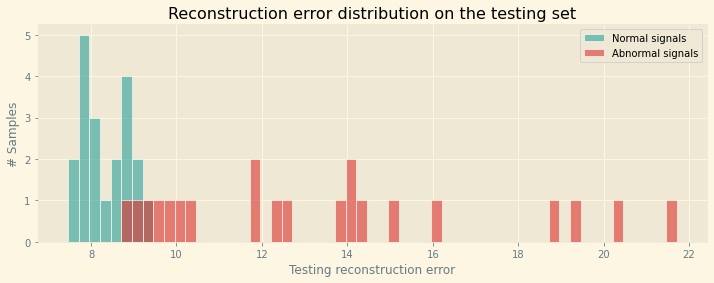

In [28]:
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))
bin_width = 0.25
bins = np.arange(min(reconstruction_errors), max(reconstruction_errors) + bin_width, bin_width)

fig = plt.figure(figsize=(12,4))
plt.hist(data[y_true==0][:,1], bins=bins, color=blue, alpha=0.6, label='Normal signals', edgecolor='#FFFFFF')
plt.hist(data[y_true==1][:,1], bins=bins, color=red, alpha=0.6, label='Abnormal signals', edgecolor='#FFFFFF')
plt.xlabel("Testing reconstruction error")
plt.ylabel("# Samples")
plt.title('Reconstruction error distribution on the testing set', fontsize=16)
plt.legend()
plt.show()

Let's explore the recall-precision trade off for a reconstruction error threshold varying between 5.0 and 10.0 (this encompasses most of the overlap we can see above). First, let's visualize how this threshold range separates our signals on a scatter plot of all the testing samples:

In [80]:
# Set threshold ranges:
'''threshold_min = 5.0
threshold_max = 10.0
threshold_step = 0.50'''

threshold_min = data[y_true==0][:,1].min()
threshold_max = data[y_true==0][:,1].max()
threshold_step = 0.50

In [81]:
data[y_true==0][:,1].max()

9.4519681930542

In [82]:
data[y_true==1][:,1].min()

8.931747436523438

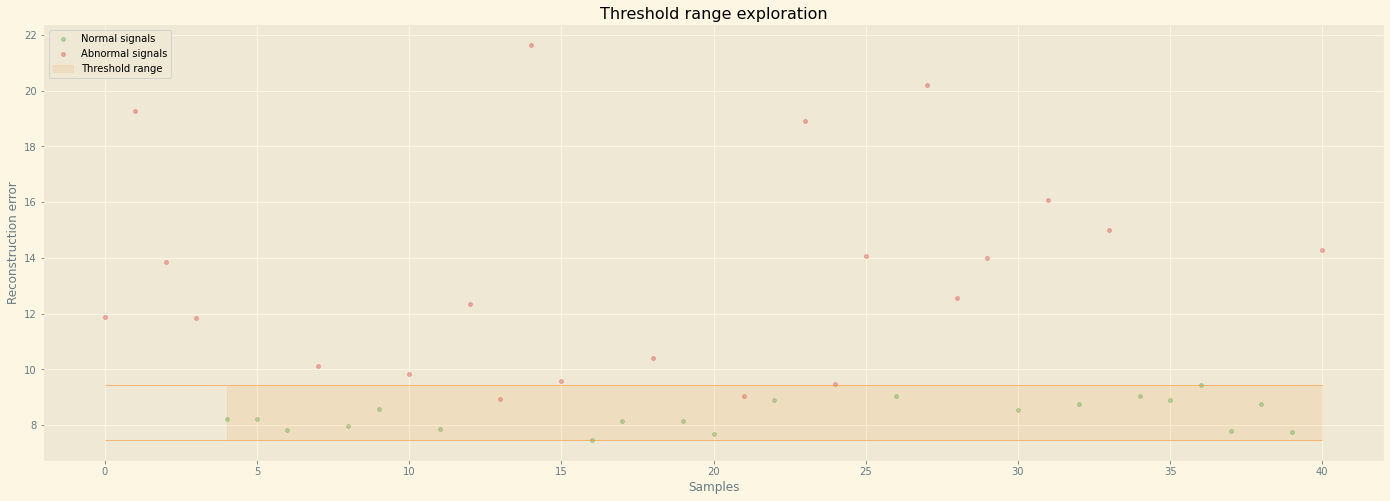

In [83]:
# Scatter data for normal and abnormal signals:
normal_x, normal_y = data[y_true==0][:,0], data[y_true==0][:,1]
abnormal_x, abnormal_y = data[y_true==1][:,0], data[y_true==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Normal signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3,   label='Abnormal signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Threshold range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:orange')
plt.legend(loc='upper left')
plt.title('Threshold range exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.show()

### Confusion matrix analysis

thresholds:  7.461148738861084
TP: 1, TN: 21, FP: 19, FN: 0
thresholds:  7.961148738861084
TP: 7, TN: 21, FP: 13, FN: 0
thresholds:  8.461148738861084
TP: 11, TN: 21, FP: 9, FN: 0
thresholds:  8.961148738861084
TP: 17, TN: 20, FP: 3, FN: 1
thresholds:  9.461148738861084
TP: 20, TN: 18, FP: 0, FN: 3


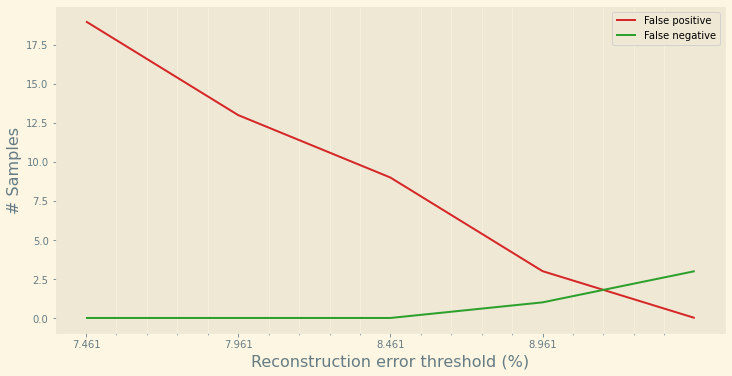

In [84]:
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pd.DataFrame(columns=['Signal', 'Ground Truth', 'Prediction', 'Reconstruction Error'])
df['Signal'] = test_files
df['Ground Truth'] = test_labels
df['Reconstruction Error'] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    print('thresholds: ', th)
    df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
    df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
    df = utils.generate_error_types(df)
    
    FN.append(df['FN'].sum())
    FP.append(df['FP'].sum())
    print('TP: %d, TN: %d, FP: %d, FN: %d' %(df['TP'].sum(),
                                             df['TN'].sum(), 
                                             df['FP'].sum(), 
                                             df['FN'].sum()))

utils.plot_curves(FP, FN, nb_samples=df.shape[0], threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step)

The above curves, shows us that the best compromise is to use a threshold set around 6.3-6.5 for the reconstruction error (assuming we are not looking at minimizing either the false positive or false negatives occurrences).

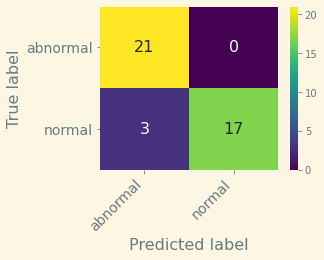

In [85]:
th = 8.931
df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
df['Prediction'] = df['Prediction'].astype(np.float32)
df = utils.generate_error_types(df)
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

from sklearn.metrics import confusion_matrix
df['Ground Truth'] = 1 - df['Ground Truth']
df['Prediction'] = 1 - df['Prediction']
utils.print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['abnormal', 'normal']);

In [86]:
df.to_csv(os.path.join(PROCESSED_DATA, 'results_autoencoder.csv'), index=False)

In [87]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(f"""Basic autoencoder metrics:
- Precision: {precision*100:.1f}%
- Recall: {recall*100:.1f}%
- Accuracy: {accuracy*100:.1f}%
- F1 Score: {f1_score*100:.1f}%""")

Basic autoencoder metrics:
- Precision: 85.0%
- Recall: 100.0%
- Accuracy: 92.7%
- F1 Score: 91.9%


## Cleanup
---

Finally, we should delete the endpoint before we close this notebook.

To do so execute the cell below. Alternately, you can navigate to the **Endpoints** tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select **Delete** from the **Actions** dropdown menu.

In [ ]:
sess.delete_endpoint(tf_predictor.endpoint_name)

## Epilogue: model improvement and further exploration
---

This spectrogram approach requires to define the spectrogram square dimensions (e.g. the number of Mel cell defined in the data exploration notebook) which is a heuristic. In contrast, deep learning networks with a CNN encoder can learn the best representation to perform the task at hands (anomaly detection). Further steps to investigate to improve on this first result could be:
* Experimenting with several more or less complex autoencoder architectures, training for a longer time, performing hyperparameter tuning with different optimizer, tuning the data preparation sequence (e.g. sound discretization parameters), etc.
* Leveraging high resolution spectrograms and feed them to a CNN encoder to uncover the most appropriate representation of the sound
* Building end-to-end model architecture with encoder-decoder: they have been known to give good results on waveform datasets.
* Using deep learning models with multi-context temporal and channel (8 microphones in this case) attention weights.
* Using time distributed 2D convolution layers to encode features across the 8 channels: these encoded features could then be fed as sequences across time steps to an LSTM or GRU layer. From there, multiplicative sequence attention weights can then be learnt on the output sequence from the RNN layer.
* Exploring the appropriate image representation for multivariate time series signal that are not waveform: replacing spectrograms with Markov transition fields, recurrence plots or network graphs could then be used to achieve the same goals for non-sound time-based signals.